#-----前期准备-----

In [166]:
#导入包
import os
import sys
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [167]:
#设置常量

#选择读入学期数
term_n = 4
#选择是否写入文件,1为是
out_to_file = 0

In [168]:
#文件与分表
file = '个人成绩记录.xls'
semesters = ['大一上学期','大一下学期','大二上学期','大二下学期','大三上学期','大三下学期','大四上学期','大四下学期']

#设置选修课：[选修课种类,需修学分,需修课程数] （若无要求则填 0）
#双学位或辅修也可在此部分实现
option_courses = [['专业', 12, 0],['通识', 6, 0], ['实践', 2, 0]]

#输出文件
file_out = '成绩分析.doc'
#修改文件输出
origin_out = sys.stdout
if out_to_file == 1:
    sys.stdout = open(file_out, mode = 'w')

#-----数据处理-----

##读取数据

In [169]:
#1-从 excel 读取数据
data = []
for i in range(term_n):
    data.append(pd.read_excel(file, semesters[i]))

##计算每学期的数据  
 1.总学分、平均分、课程数、加权绩点(每学期)  
 2.选修课情况  
 3.成绩分布情况

In [170]:
#函数-将分数转为对应绩点
def grade_to_point(grades):
    table_grades = [60,64, 68, 72, 75, 78, 82, 85, 90]
    table_point = [1.3, 1.5, 2, 2.3, 2.7, 3, 3.3, 3.7, 4]
    n = len(grades)
    ret = []
    for j in range(n):
        m = grades[j]
        n = 0
        for i in range(len(table_grades)):
            if(m >= table_grades[i]):
                n = table_point[i]

        ret.append( n)
    return ret

def trans_sort(text):
    if '通识' in text:
        return '通识'
    elif '实践' in text:
        return '实践'
    else:
        return '专业'

In [171]:
#2.1-记录每学期的数据

#格式：【总， 选】
credits_term = [] #总学分
courses_term = [] #课程数
grades_term = []  #平均分
points_term = []  #加权绩点

#记录选修课情况(所有学期)
#格式 [课程名， 选修类型， 学分， 分数]
courses_opt = []

#记录每学期成绩分布情况
grades_distrib = []
grades_distrib_all = {'98~100':0,'95~97':0, '90~94':0, '85~89':0, '80~84':0, '70~79':0}
distrib_term = {'98~100':0,'95~97':0, '90~94':0, '85~89':0, '80~84':0, '70~79':0}
distrib_ = [98, 95, 90, 85, 80, 70] #分档分数

In [172]:
#2.2-计算每学期的数据

for j in range(term_n):
    #读取每学期数据
    credit = data[j]['学分']
    course = data[j]['课程']
    grade = data[j]['分数']
    point = grade_to_point(grade)
    
    sort = data[j]['课程类型']
    
    #记录当前学期数据
    credit_ = [0,0]
    grade_ = [0,0]
    course_ = [0,0]
    point_ = [0,0]
    
    #考虑 选修、必修
    for i in range(len(sort)):
        #所有课程
        credit_[0] += credit[i]
        course_[0] += 1
        grade_[0] += grade[i] * credit[i]
        point_[0] += point[i] * credit[i]

        if '选修' not in sort[i]:
            credit_[1] += credit[i]
            course_[1] += 1
            grade_[1]  += grade[i] * credit[i]
            point_[1]  += point[i] * credit[i]
        #记录选修课情况
        if '选修' in sort[i]:
            courses_opt.append([course[i], trans_sort(sort[i]), credit[i], grade[i]])
            
        #记录学期成绩分布
        dis_term = copy.deepcopy(distrib_term)
        grades_distrib.append(dis_term)
        if grade[i] >= distrib_[0]:
            grades_distrib[j]['98~100'] += 1
            grades_distrib_all['98~100'] += 1
        elif grade[i] >= distrib_[1]:
            grades_distrib[j]['95~97'] += 1
            grades_distrib_all['95~97'] += 1
        elif grade[i] >= distrib_[2]:
            grades_distrib[j]['90~94'] += 1
            grades_distrib_all['90~94'] += 1
        elif grade[i] >= distrib_[3]:
            grades_distrib[j]['85~89'] += 1
            grades_distrib_all['85~89'] += 1
        elif grade[i] >= distrib_[4]:
            grades_distrib[j]['80~84'] += 1
            grades_distrib_all['80~84'] += 1
        elif grade[i] >= distrib_[5]:
            grades_distrib[j]['70~79'] += 1
            grades_distrib_all['70~79'] += 1
        else:
            print('?')
            
    #记录每学期数据
    credits_term.append(credit_)
    courses_term.append(course_)
    grades_term.append([grade_[0] / credit_[0], grade_[1] / credit_[1]])
    points_term.append([point_[0] / credit_[0], point_[1] / credit_[1]]) 
    

In [173]:
#2.3整理选修课情况
courses_opt_n = len(courses_opt)

#计算选修课学分情况
credit_option = {'专业':0, '通识':0, '实践':0}

for i in range(courses_opt_n):
    for key, value in credit_option.items():
        if courses_opt[i][1] == key:
            credit_option[key] +=  courses_opt[i][2]

In [174]:
print(len(grades_distrib))

#-----结果输出-----

In [175]:
#绘图
def show_distribution(dict_data):
    fig = plt.figure()
    ax = fig.add_subplot()
    data_show = []
    index_show = []
    for key, value in dict_data.items():
        data_show.append(value)
        index_show.append(key)
    grades_show = pd.Series(data_show, index_show)
    grades_show.plot.bar(ax)
    
def get_avg(data, k):
    n = len(data)
    avg, credit_ = 0, 0
    for i in range(n):
        avg += data[i][k] * credits_term[i][k]
        credit_ += credits_term[i][k]
    return avg/credit_

def get_sum(data, k):
    n = len(data)
    ret = 0
    for i in range(n):
        ret += data[i][k]
    return ret

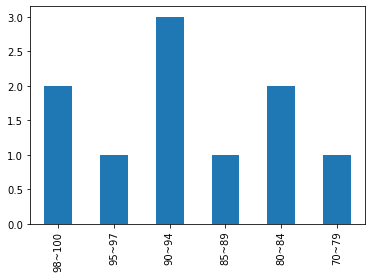

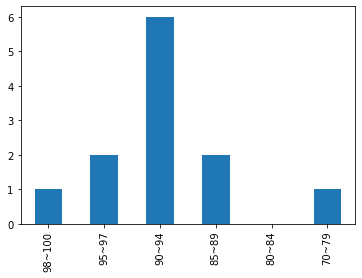

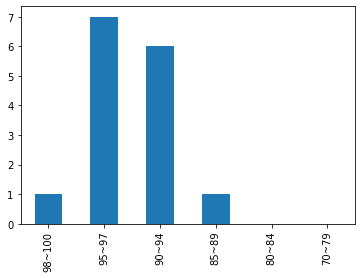

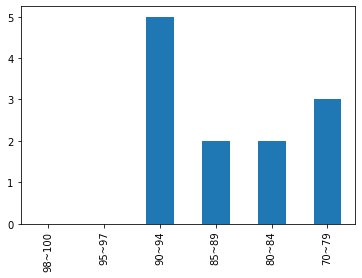

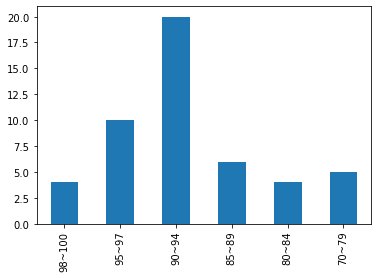

In [176]:
for i in range(term_n):
    print('-'*50)
    print(semesters[i])
    print('-'*20)
    #基本数据展示
    print('本学期所修学分:  {:,.2f}(必修) , {:,.2f}(总共)'.format(credits_term[i][1],credits_term[i][0]))
    print('本学期所修课程:  {:,.0f}门(必修) , {:,.0f}门(总共)'.format(courses_term[i][1],courses_term[i][0]))
    print('必修课程:   grades: {:,.3f} , point: {:,.3f}'.format(grades_term[i][1] ,points_term[i][1]))
    print('所有课程:   grades: {:,.3f} , point: {:,.3f}'.format(grades_term[i][0] ,points_term[i][0]))
    #成绩分布
    show_distribution(grades_distrib[i])
#展示总数据
print('-'*50)
print('直至' + semesters[term_n-1])
print('共修学分/分:     {:,.2f}(必修) , {:,.2f}(总共)'.format(get_sum(credits_term, 1),get_sum(credits_term , 0)))
print('共修课程/门:        {:,.0f}(必修) ,     {:,.0f}(总共)'.format(get_sum(courses_term, 1),get_sum(courses_term, 0)))
print('必修课程:  grades: {:,.3f} , point: {:,.3f}'.format(get_avg(grades_term, 1) ,get_avg(points_term, 1)))
print('所有课程:  grades: {:,.3f} , point: {:,.3f}'.format(get_avg(grades_term, 0) ,get_avg(points_term, 0)))
print('-'*10,'选修课情况','-'*10)
#成绩分布
show_distribution(grades_distrib_all)